In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from pprint import pprint

%matplotlib inline 

In [2]:
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

# Read data in

In [3]:
users = pd.read_csv("takehome_users.csv", encoding="ISO-8859-1")
engage = pd.read_csv("takehome_user_engagement.csv")

In [4]:
# Convert to a date  create a week object
engage['time_stamp'] = pd.to_datetime(engage['time_stamp'])
engage['week'] = engage['time_stamp'].dt.week

# Create adopoted user

In [5]:
user_by_week = engage.groupby(['user_id', 'week'])['visited'].sum().to_frame(name='cnt')
adopoted_user = user_by_week[user_by_week['cnt'] >= 3].reset_index()['user_id'].unique()

In [6]:
# Add in adopted user 
users['adopted_user'] = users.apply(lambda x:1 if x['object_id'] in adopoted_user else 0, axis = 1)

In [7]:
users['adopted_user'].value_counts(normalize=True)

0    0.879583
1    0.120417
Name: adopted_user, dtype: float64

# Create other variables

In [8]:
# Fix dates
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit ='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['hr'] = users['creation_time'].dt.hour

In [9]:
# Was the reference adopoted?
users['reference_adopted'] = users.apply(lambda x:1 if x['invited_by_user_id'] in adopoted_user else 0, axis = 1)

In [10]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,hr,reference_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,3,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,3,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,23,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,8,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,10,1


In [11]:
users[['invited_by_user_id', 'reference_adopted']].drop_duplicates()['reference_adopted'].value_counts(normalize=True)

0    0.845614
1    0.154386
Name: reference_adopted, dtype: float64

In [12]:
# Creation source
users = pd.concat([users, 
                   pd.get_dummies(users['creation_source'], prefix="creation"), 
                   pd.get_dummies(users['org_id'], prefix="org")
                  ], 1)

In [13]:
# Email providers 
users['provider'] = users.apply(lambda x: x['email'].lower().split("@")[1], axis = 1)

# Create provider recode 
top_providers = users['provider'].value_counts().to_frame('cnt')
top_providers_vals = top_providers[top_providers['cnt'] >2].reset_index()['index'].values
users['provider_r'] = users.apply(lambda x: x['provider'] if x['provider'] in top_providers_vals else 'other', axis = 1)

# Dummy code provider 
users = pd.concat([users, pd.get_dummies(users['provider_r'], prefix='prov')], 1)

# Final Analysis Dataset

In [14]:
drop_vars = ['object_id', 'creation_time', 'name', 'email', 'creation_source', 'last_session_creation_time', 
             'org_id', 'invited_by_user_id', 'provider', 'provider_r'
            ]

In [15]:
analysis_data = users.drop(columns = drop_vars)

# Basic Exploration

In [16]:
analysis_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 434 columns):
opted_in_to_mailing_list       int64
enabled_for_marketing_drip     int64
adopted_user                   int64
hr                             int64
reference_adopted              int64
creation_GUEST_INVITE          uint8
creation_ORG_INVITE            uint8
creation_PERSONAL_PROJECTS     uint8
creation_SIGNUP                uint8
creation_SIGNUP_GOOGLE_AUTH    uint8
org_0                          uint8
org_1                          uint8
org_2                          uint8
org_3                          uint8
org_4                          uint8
org_5                          uint8
org_6                          uint8
org_7                          uint8
org_8                          uint8
org_9                          uint8
org_10                         uint8
org_11                         uint8
org_12                         uint8
org_13                         uint8
or

In [17]:
pd.options.display.max_rows = 999
analysis_data.describe().T

,count,mean,std,min,25%,50%,75%,max
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.0,0.0,0.0,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.0,0.0,0.0,1.0
adopted_user,12000.0,0.120417,0.325462,0.0,0.0,0.0,0.0,1.0
hr,12000.0,11.564333,6.914888,0.0,6.0,12.0,18.0,23.0
reference_adopted,12000.0,0.083917,0.277274,0.0,0.0,0.0,0.0,1.0
creation_GUEST_INVITE,12000.0,0.180250,0.384412,0.0,0.0,0.0,0.0,1.0
creation_ORG_INVITE,12000.0,0.354500,0.478381,0.0,0.0,0.0,1.0,1.0
creation_PERSONAL_PROJECTS,12000.0,0.175917,0.380765,0.0,0.0,0.0,0.0,1.0
creation_SIGNUP,12000.0,0.173917,0.379054,0.0,0.0,0.0,0.0,1.0
creation_SIGNUP_GOOGLE_AUTH,12000.0,0.115417,0.319537,0.0,0.0,0.0,0.0,1.0


In [18]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['opted_in_to_mailing_list'], 
            normalize = True
           )

opted_in_to_mailing_list,0,1
adopted_user,,
0,0.661583,0.2180
1,0.088917,0.0315


In [19]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['enabled_for_marketing_drip'], 
            normalize = True
           )

enabled_for_marketing_drip,0,1
adopted_user,,
0,0.748917,0.130667
1,0.101750,0.018667


In [20]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['reference_adopted'], 
            normalize = True
           )

reference_adopted,0,1
adopted_user,,
0,0.811500,0.068083
1,0.104583,0.015833


In [21]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['creation_GUEST_INVITE'], 
            normalize = True
           )

creation_GUEST_INVITE,0,1
adopted_user,,
0,0.72650,0.153083
1,0.09325,0.027167


In [22]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['creation_ORG_INVITE'], 
            normalize = True
           )

creation_ORG_INVITE,0,1
adopted_user,,
0,0.5660,0.313583
1,0.0795,0.040917


In [23]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['creation_PERSONAL_PROJECTS'], 
            normalize = True
           )

creation_PERSONAL_PROJECTS,0,1
adopted_user,,
0,0.715917,0.163667
1,0.108167,0.012250


In [24]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['creation_SIGNUP'], 
            normalize = True
           )

creation_SIGNUP,0,1
adopted_user,,
0,0.728583,0.151000
1,0.097500,0.022917


In [25]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['creation_SIGNUP_GOOGLE_AUTH'], 
            normalize = True
           )

creation_SIGNUP_GOOGLE_AUTH,0,1
adopted_user,,
0,0.781333,0.098250
1,0.103250,0.017167


In [26]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['prov_cuvox.de'], 
            normalize = True
           )

prov_cuvox.de,0,1
adopted_user,,
0,0.789583,0.090000
1,0.110250,0.010167


In [27]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['prov_gmail.com'], 
            normalize = True
           )

prov_gmail.com,0,1
adopted_user,,
0,0.622667,0.256917
1,0.080500,0.039917


In [28]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['prov_gustr.com'], 
            normalize = True
           )

prov_gustr.com,0,1
adopted_user,,
0,0.792167,0.087417
1,0.109583,0.010833


In [29]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['prov_hotmail.com'], 
            normalize = True
           )

prov_hotmail.com,0,1
adopted_user,,
0,0.797583,0.082000
1,0.105333,0.015083


In [30]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['prov_jourrapide.com'], 
            normalize = True
           )

prov_jourrapide.com,0,1
adopted_user,,
0,0.787250,0.092333
1,0.107833,0.012583


In [31]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['prov_other'], 
            normalize = True
           )

prov_other,0,1
adopted_user,,
0,0.793083,0.086500
1,0.108083,0.012333


In [32]:
pd.crosstab(analysis_data['adopted_user'], 
            analysis_data['prov_yahoo.com'], 
            normalize = True
           )

prov_yahoo.com,0,1
adopted_user,,
0,0.695167,0.184417
1,0.100917,0.019500


# Logistic Regression

In [33]:
columns = list(analysis_data.drop(columns='adopted_user').columns)

In [34]:
columns = [x for x in columns if 'org_' not in x ]

In [35]:
columns

['opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'hr',
 'reference_adopted',
 'creation_GUEST_INVITE',
 'creation_ORG_INVITE',
 'creation_PERSONAL_PROJECTS',
 'creation_SIGNUP',
 'creation_SIGNUP_GOOGLE_AUTH',
 'prov_cuvox.de',
 'prov_gmail.com',
 'prov_gustr.com',
 'prov_hotmail.com',
 'prov_jourrapide.com',
 'prov_other',
 'prov_yahoo.com']

In [36]:
# Subset variables for train/test split
X = analysis_data[columns].values
y = analysis_data['adopted_user'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [38]:
lg = LogisticRegressionCV(random_state = 42, cv = 3)

# Fit the model

In [39]:
lg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

# Score the training data

In [40]:
lg.score(X_train, y_train)

0.87960199004975126

# Scoring Test Data

In [41]:
lg.score(X_test, y_test)

0.87954545454545452

# Plot the train data

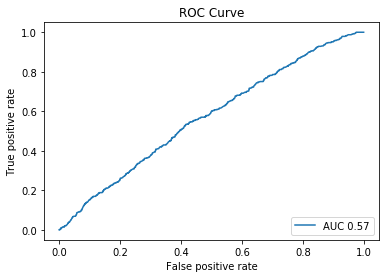

In [42]:
y_pred = lg.predict(X_test)
y_pred_proba = lg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC" + " {:0.2f}".format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC Curve")
plt.legend(loc=4);

In [43]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94      3483
          1       0.00      0.00      0.00       477

avg / total       0.77      0.88      0.82      3960



/home/craig/anaconda2/envs/springboard/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
_vars = X = analysis_data.drop(columns='adopted_user').columns
lg_coef = pd.DataFrame(list(zip(_vars, lg.coef_[0])), columns=['features', 'coef'])
lg_coef.sort_values('coef', ascending=False)

,features,coef
3,reference_adopted,0.004448
4,creation_GUEST_INVITE,0.003519
10,org_1,0.003070
12,org_3,0.002976
8,creation_SIGNUP_GOOGLE_AUTH,0.001975
7,creation_SIGNUP,0.001705
0,opted_in_to_mailing_list,0.001156
1,enabled_for_marketing_drip,0.001060
14,org_5,0.000557
13,org_4,0.000187


# Random Forest Classifier 

In [45]:
forest = RandomForestClassifier()

In [46]:
steps = [('forest', forest)]

In [47]:
pipe = Pipeline(steps)

In [48]:
grid_parameters = {  
                            'forest__criterion': ['entropy'], 
                            'forest__max_depth':[x for x in range(1,15)], 
                            'forest__n_estimators':[100, 250, 500, 750, 1000, 1250], 
                            'forest__n_jobs':[-1], 
                            'forest__random_state':[42], 
                            'forest__min_samples_split':[20], 
                           }

In [49]:
grid = GridSearchCV(pipe, grid_parameters, cv=3)
grid.fit(X=X_train, y=y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'forest__criterion': ['entropy'], 'forest__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'forest__n_estimators': [100, 250, 500, 750, 1000, 1250], 'forest__n_jobs': [-1], 'forest__random_state': [42], 'forest__min_samples_split': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
tree_model = grid.best_estimator_
print("Accuracy: {:0.2f}".format(grid.best_score_) )
print("Best Parameters:\t") 
pprint(grid.best_params_) 

Accuracy: 0.88
Best Parameters:	
{'forest__criterion': 'entropy',
 'forest__max_depth': 1,
 'forest__min_samples_split': 20,
 'forest__n_estimators': 100,
 'forest__n_jobs': -1,
 'forest__random_state': 42}


In [51]:
print('Test score: {:0.2f}'.format(grid.score(X_test, y_test)))

Test score: 0.88


# Predict Test

In [52]:
y_pred = grid.predict(X_test)

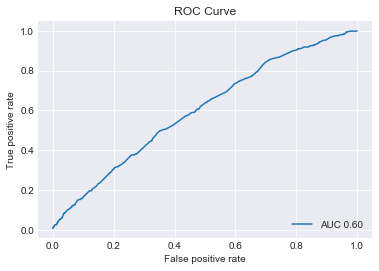

In [53]:
# Set seaborn style 
sns.set_style("darkgrid")

y_pred_proba = grid.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC" + " {:0.2f}".format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC Curve")
plt.legend(loc=4);

In [54]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      1.00      0.94      3483
          1       0.00      0.00      0.00       477

avg / total       0.77      0.88      0.82      3960



/home/craig/anaconda2/envs/springboard/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Feature Importance

In [55]:
feature_importance = grid.best_estimator_.named_steps['forest'].feature_importances_
x = list(zip(_vars, feature_importance))
importance = pd.DataFrame(x, columns=['var', 'importance'])

In [56]:
# Print the importance values 
importance.sort_values('importance', ascending = False)

,var,importance
6,creation_PERSONAL_PROJECTS,0.24
3,reference_adopted,0.17
15,org_6,0.15
4,creation_GUEST_INVITE,0.10
12,org_3,0.08
2,hr,0.06
10,org_1,0.06
8,creation_SIGNUP_GOOGLE_AUTH,0.05
9,org_0,0.04
0,opted_in_to_mailing_list,0.02
